# Generative Modeling by Estimating Gradients of the Data Distribution

Paper: [Song and Ermon (2019)](https://arxiv.org/abs/1907.05600)

End-of-day notes (implementation PDG #13):

* The implementation was way easier than the EBMs and diffusion models were.
* We did not manage to generate samples with the model.
* A hparam sweep would be the logical next step.

### Imports and Data Loading

In [1]:
from typing import *

from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np
import sklearn.datasets
import torch
from tqdm import tqdm

In [2]:
dataset = sklearn.datasets.load_digits()
data_np, labels_np = dataset['data'], dataset['target']
data_np = data_np[labels_np == 1]
del labels_np

In [3]:
data_np.shape

(182, 64)

In [4]:
data = torch.from_numpy(data_np.astype(np.float32))
# data = (data - torch.mean(data, axis=0)) / (torch.std(data, axis=0) + 1e-7)
data = ((data / 15) - 0.5) * 2  # Normalize between [-1, 1]

In [5]:
data[0]

tensor([-1.0000, -1.0000, -1.0000,  0.6000,  0.7333, -0.3333, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000,  0.4667,  1.1333,  0.2000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.6000,  1.0000,  1.1333, -0.2000, -1.0000, -1.0000,
        -1.0000, -0.0667,  1.0000,  1.1333,  1.1333, -0.7333, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.8667,  1.1333,  1.1333, -0.6000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.8667,  1.1333,  1.1333, -0.2000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.8667,  1.1333,  1.1333, -0.2000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000,  0.4667,  1.1333,  0.3333, -1.0000, -1.0000])

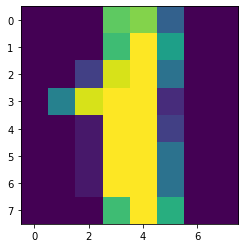

In [6]:
plt.imshow(data_np[0].reshape((8, 8)));

### Hparams

In [7]:
SIGMA = .2
NUM_EPOCHS = 500
LEARNING_RATE = 1e-3

### Model Definition

In [8]:
score_nn = torch.nn.Sequential(
    torch.nn.Linear(in_features=64, out_features=20),
    torch.nn.SiLU(),
    torch.nn.Linear(in_features=20, out_features=20),
    torch.nn.SiLU(),
    torch.nn.Linear(in_features=20, out_features=64),
)

In [9]:
class NoiseConditionalScoreNN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fnn = torch.nn.Sequential(
            torch.nn.Linear(in_features=64+1, out_features=20),
            torch.nn.SiLU(),
            torch.nn.Linear(in_features=20, out_features=20),
            torch.nn.SiLU(),
            torch.nn.Linear(in_features=20, out_features=64),
        )
    
    def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        return self.fnn(torch.concat([x, torch.tensor([noise])]))

In [10]:
noise_cond_score_nn = NoiseConditionalScoreNN()

### Loss: Denoising Score Matching

**Eq. (2)**

Defining this as an object because we'll have to compute its grad.

In [11]:
def loss_dsm(data: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    loss_sum = torch.zeros(1)
    
    for x in data:
        q = torch.distributions.MultivariateNormal(x, SIGMA * torch.eye(x.shape[0]))
        x_tilde = q.sample()
        x_tilde.requires_grad = True
        q_log_prob = q.log_prob(x_tilde)
        nabla_q_wrt_x_tilde = torch.autograd.grad(outputs=[q_log_prob], inputs=x_tilde)[0]
        
        score = model(x_tilde)
        
        loss_sum += torch.linalg.norm(score - nabla_q_wrt_x_tilde.detach(), ord=2) ** 2 / 2
    
    return loss_sum

### Loss: Noise Conditional Score Matching

**Eq. (5) and (6)**

The network is provided an additional input, the noise.

In [12]:
SIGMAS = torch.linspace(1, 0.01, 5)
SIGMAS

tensor([1.0000, 0.7525, 0.5050, 0.2575, 0.0100])

In [13]:
def loss_ncsm(data: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    """Eq. (5) & (6)"""
    loss_sum = torch.zeros(1)
    
    for sigma in SIGMAS:
        for x in data:
            q = torch.distributions.MultivariateNormal(x, sigma * torch.eye(x.shape[0]))
            x_tilde = q.sample()
            x_tilde.requires_grad = True
            q_log_prob = q.log_prob(x_tilde)
            nabla_q_wrt_x_tilde = torch.autograd.grad(outputs=[q_log_prob], inputs=x_tilde)[0]

            score = model(x_tilde, sigma)
            lamda = sigma ** 2

            loss_sum += lamda * torch.linalg.norm(score - nabla_q_wrt_x_tilde.detach(), ord=2) ** 2 / 2
    
    return loss_sum / len(SIGMAS)

### Train Loop

In [14]:
def train(data: torch.Tensor, model: torch.nn.Module, loss_fn: Callable, num_epochs: int):
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_stats = defaultdict(list)
    
    for _ in tqdm(range(num_epochs)):
        opt.zero_grad()
        loss_val = loss_fn(data, model)
        loss_val.backward()
        opt.step()
        
        train_stats['loss'].append(loss_val.item())
        
    return model, train_stats

100%|██████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.64it/s]


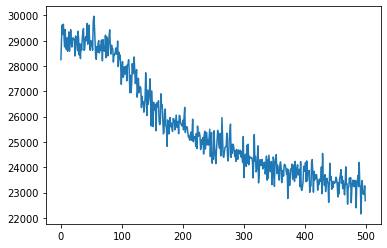

In [15]:
score_nn, train_stats = train(data, score_nn, loss_dsm, NUM_EPOCHS)
plt.plot(train_stats['loss']);

100%|██████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


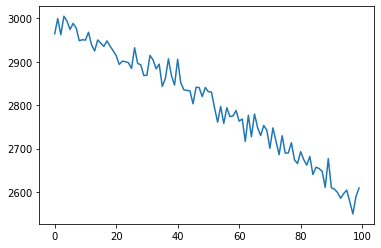

In [17]:
noise_cond_score_nn, train_stats_ncsm = train(
    data, noise_cond_score_nn, loss_ncsm, num_epochs=NUM_EPOCHS // len(SIGMAS))
plt.plot(train_stats_ncsm['loss']);

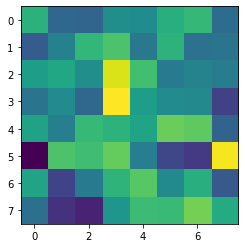

In [18]:
plt.imshow(score_nn(torch.zeros((64,))).detach().numpy().reshape((8, 8)));

### Sampling with Langevin Dynamics

In [19]:
NUM_LANGEVIN_STEPS = 1000
EPS = .1  # Suggested tuning range: [.1, 1e-6]

In [20]:
z_dist = torch.distributions.MultivariateNormal(torch.zeros(64), torch.eye(64))

In [21]:
def sample(model: torch.nn.Module, start_from_data: int = -1) -> Iterable[torch.Tensor]:
    if start_from_data >= 0:
        x_0 = data[start_from_data]
    else:
        x_0 = torch.zeros((64,))
    
    yield x_0
    
    x_t = x_0
    for step in range(NUM_LANGEVIN_STEPS):
        z_t = z_dist.sample()
        x_t = x_t + EPS / 2 * model(x_t) + math.sqrt(EPS) * z_t
        if step % 100 == 0:
            yield x_t.detach().numpy()

In [22]:
def plot_langevin_output(sampling_fn, model, start_from_data: List[int]):
    dry_run = sampling_fn(model)
    num_columns = len(list(dry_run))
    fig, ax = plt.subplots(len(start_from_data), num_columns, figsize=(num_columns, len(start_from_data)))

    for i, data_idx in enumerate(range(len(start_from_data))):
        for j, x_sample in enumerate(sampling_fn(model, data_idx)):
            ax[i][j].imshow(x_sample.reshape((8, 8)))
            ax[i][j].axis('off')

    plt.tight_layout()

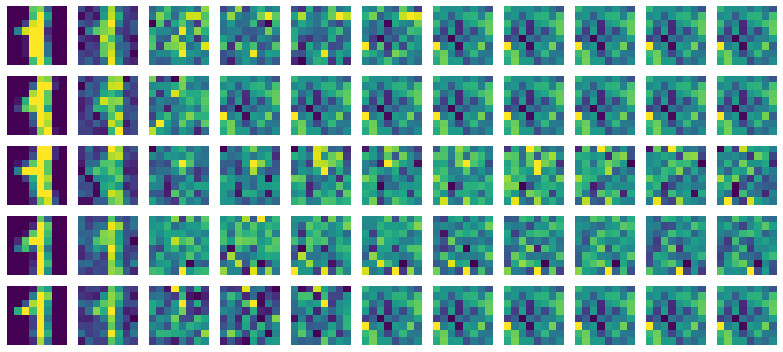

In [23]:
plot_langevin_output(sample, score_nn, list(range(5)))

In [24]:
def sample_annealed(model: torch.nn.Module, start_from_data: int = -1) -> Iterable[torch.Tensor]:
    """Algorithm 1."""
    if start_from_data >= 0:
        x_0 = data[start_from_data]
    else:
        x_0 = torch.zeros((64,))
    yield x_0
    
    x_t = x_0
    for sigma in SIGMAS:  # Iterate over noise levels.
        alpha_i = EPS * sigma ** 2 / SIGMAS[-1] ** 2
        for step in range(NUM_LANGEVIN_STEPS):
            z_t = z_dist.sample()

            x_t = x_t + alpha_i / 2 * model(x_t, sigma) + math.sqrt(alpha_i) * z_t
            if step % (100 * len(SIGMAS)) == 0:
                yield x_t.detach().numpy()

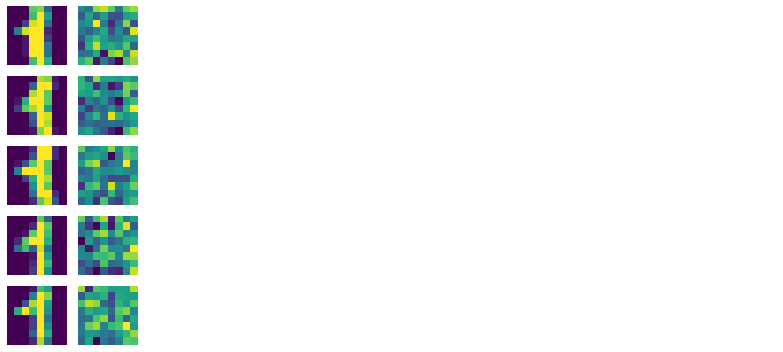

In [25]:
plot_langevin_output(sample_annealed, noise_cond_score_nn, list(range(5)))